# Data loading

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from clean_data import read_delta_data

data = read_delta_data("./data/Turnstile_Usage_Data__2018.csv", pickle_ok=True)

In [33]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Pull out target stations

In [34]:
target_stations = pd.read_csv("station_targets.csv")
target_stations = target_stations.Station.str.upper()

In [35]:
target_stations = ['34 ST-PENN STA', 
                   'GRD CNTRL-42 ST', 
                   '14 ST-UNION SQ', 
                   'W 4 ST-WASH SQ',
                  'WALL ST']

# Bin out data by stations and weekend/weekday

In [36]:
data = data[data.Station.isin(target_stations)].reset_index()
station_group = data.groupby(['Station', 'b_weekday'])

In [37]:
t = target_stations[0]
t_data = station_group.get_group((t,True))
t_data.head(3)

,index,C/A,Unit,SCP,Station,Description,Entries,Exits,ts_id,date_time,b_weekday,Weekday,entry_delta,exit_delta,time_delta,hour,people_ph
18650,396757,N067,R012,00-00-00,34 ST-PENN STA,REGULAR,1993852,1969783,R012_00-00-00,2018-04-02 00:00:00,True,Monday,44.0,98.0,04:00:00,0,35.50
18651,396758,N067,R012,00-00-00,34 ST-PENN STA,REGULAR,1993855,1969791,R012_00-00-00,2018-04-02 04:00:00,True,Monday,3.0,8.0,04:00:00,4,2.75
18652,396759,N067,R012,00-00-00,34 ST-PENN STA,REGULAR,1993971,1969972,R012_00-00-00,2018-04-02 08:00:00,True,Monday,116.0,181.0,04:00:00,8,74.25



# Main loop begins here

In [38]:
station_titles = {'23 ST': '23rd Street',
         '14 ST': '14th Street',
         '14 ST-UNION SQ': '14th Street-Union Square',
         'LEXINGTON AV/63': 'Lexington Ave/63rd Street',
        '53 ST': '53rd Street',
         'BEDFORD AV': 'Bedford Ave',
        '7 AV': '7th Ave',
         '57 ST': '57th Street',
         'GRD CNTRL-42 ST': 'Grand Central Station',
        '8 ST-NYU': '8th Street-NYU',
         'W 4 ST-WASH SQ': 'West 4th Street-Washington Square',
         '51 ST': '51st Street',
        'WALL ST': 'Wall Street',
         'BROAD ST': 'Broad Street',
         'CHAMBERS ST': 'Chambers Street',
         '18 ST': '18th Street',
         'HOUSTON ST': 'Houston Street',
         '28 ST': '28th Street',
         'FULTON ST': 'Fulton Street',
         '34 ST-PENN STA': '34th Street-Penn Station',
         'ASTOR PL': 'Astor Place',
         '42 ST-BRYANT PK': '42nd Street-Bryant Park',
         '9TH STREET': '9th Street',
         '5 AVE': '5th Ave'}

In [39]:
def round_hours(x):
    if x.minute > 31:
        h = x.hour + 1
    else:
        h = x.hour
        
    rem = h % 4
    if rem == 1:
        h -= 1
    elif rem == 2:
        h -= 2
    elif rem == 3:
        h += 1 
        
    return h % 24
    

In [57]:
def barplot(station, bars):
    
    pretty_station = station_titles[station]
    
    weekday_enters = bars['Weekday'][0]
    weekday_exits  = bars['Weekday'][1]
    
    weekend_enters = bars['Weekend'][0]
    weekend_exits  = bars['Weekend'][1]
    
    maxy = max(weekday_enters + weekday_exits + weekend_enters + weekend_exits )
    
    x = range(24)
    
    plt.figure(figsize=(16,4))
    plt.suptitle(pretty_station, fontsize = 16)
    
    bar_width = 1.5
    x2 = [ ix + bar_width for ix in x ]
    opacity = 0.4
    
    ax = plt.subplot(1,2,1) # (number of rows, number of columns, number of plot)
    plt.bar(x, weekday_enters, bar_width,
            alpha=0.6, color='cornflowerblue',
            label="Entries")
    plt.bar(x2, weekday_exits, bar_width,
           alpha=opacity,  color='orange',
           label="Exits")
    plt.title("Monday - Friday")
    ax.set_ylim(0, maxy)
    ax.set_xlim(-1, 23)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylabel("Relative Passenger Activity")
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([3,8,13,18])
    for l in ax.get_xaxis().get_ticklines():
        l.set_markersize(0)
    ax.get_xaxis().set_ticklabels(["wee hours", "morning", "afternoon", "evening"])
    
    ax = plt.subplot(1,2,2)
    plt.bar(x, weekend_enters, bar_width,
            alpha=0.6, color='cornflowerblue',
            label="Entries")
    plt.bar(x2, weekend_exits, bar_width,
           alpha=opacity,  color='orange',
           label="Exits")
    plt.title("Weekends")
    ax.set_ylim(0, maxy)
    ax.set_xlim(-1, 23)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_ticks([])
    ax.tick_params(left=False)
    ax.get_xaxis().set_ticks([3,8,13,18])
    ax.get_xaxis().set_ticklabels(["wee hours", "morning", "afternoon", "evening"])
    for l in ax.get_xaxis().get_ticklines():
        l.set_markersize(0)
    
    plt.legend()

    plt.tight_layout()
    
    
    filename = "./plots/" + station.replace(' ','_').replace('/', '') + ".svg"
    plt.savefig(filename)
    plt.show()
    return
    
  

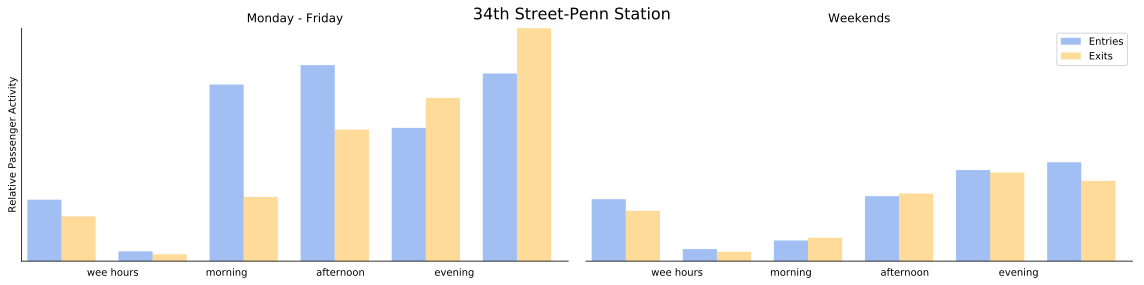

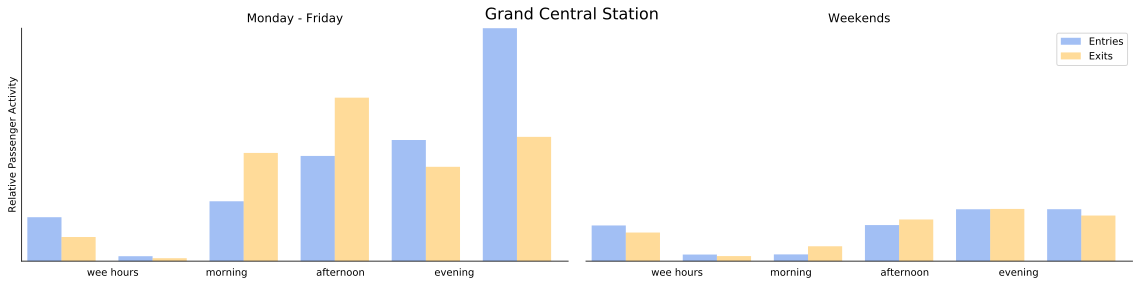

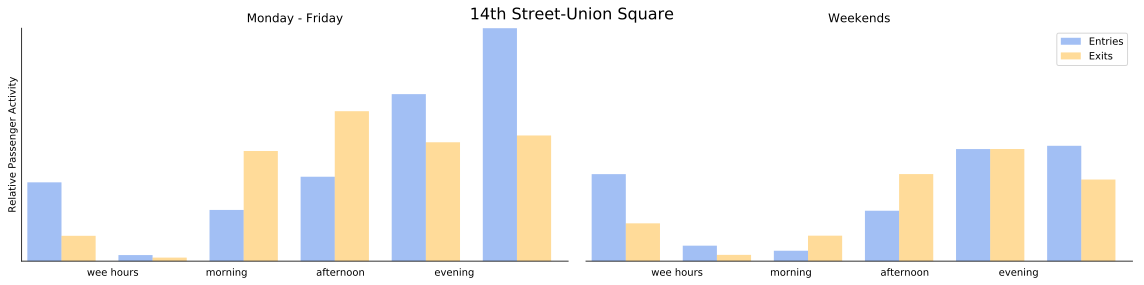

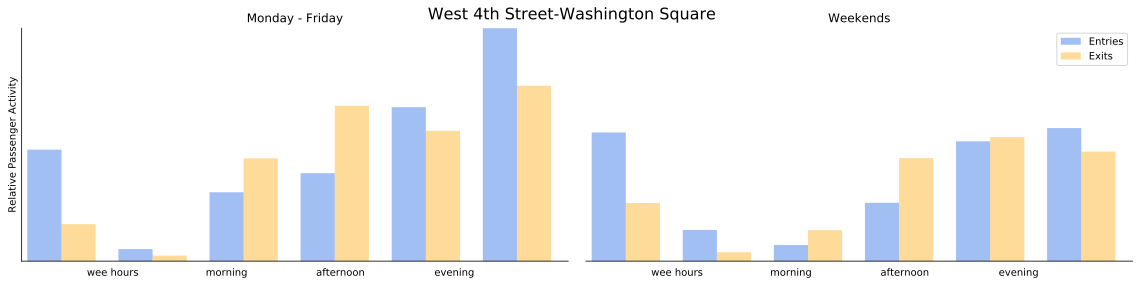

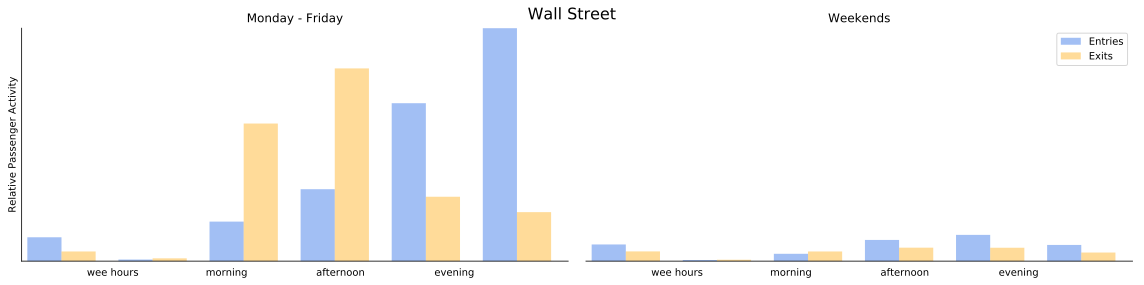

In [58]:
  
for t in target_stations:
    result_dict = {}
        
    for weekday in [True, False]:
        
        if weekday:
            daybin_name = "Weekday" 
            ## weight each weekday by 20%
            scale_by = 0.20
        else:
            daybin_name = "Weekend" 
            ## weight each weekend day by 50% 
            scale_by = 0.50
            
        group = station_group.get_group((t, weekday))
        hours = group.date_time.apply(round_hours)
        
        entry_nulls = group.entry_delta.isna()
        exit_nulls = group.exit_delta.isna()
        
        entries = group.entry_delta.copy()
        entries[entry_nulls] = 0
        
        exits = group.exit_delta.copy()
        exits[exit_nulls] = 0
        
        hourly_ents = [0] * 24
        hourly_exts = [0] * 24
        
        for entr,exts,hour in zip(entries, exits, hours):
            
            ent_bump =  entr * scale_by 
            ext_bump =  exts * scale_by
            
            hourly_ents[hour] += ent_bump
            hourly_exts[hour] += ext_bump
            
        result_dict[daybin_name] = [ hourly_ents, hourly_exts ] 
        
    barplot(t, result_dict)
                